In [1]:
#Inicialización de librerías

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from datetime import timedelta

In [2]:
%%time
#Etapa inicial lectura de datos

# Genera lista de archivos a procesar
csv_files = glob.glob('./Dataset/9???.csv')

# Lectura de archivo de definicion de ATMs
csv_def = pd.read_csv('./Dataset/definicion.csv', sep=';', squeeze=True,index_col='TERM_ID')

# Se define una variable que  con estructura de array de dataframes
list_data = []
  
# Escribimos un loop que irá a través de cada uno de los nombres de archivo a través de globbing y el resultado final será la lista dataframes
for filename in csv_files:
    data = pd.read_csv(filename, usecols = ['TERMINAL_NUMBER', 'TIMESTAMP', 'MONTO_TRX',], sep=';',parse_dates=True, squeeze=True)
    data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP'], dayfirst=True)
    list_data.append(data)
    
#Se consolidan todos los dataframe generados
df = pd.concat(list_data,ignore_index=True)

#Se despliega información resumida del dataframe generado
print (df.info())
print ('Total Registros Nulos: ', df.isnull().sum().sum())
df


df.to_csv('.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4773308 entries, 0 to 4773307
Data columns (total 3 columns):
 #   Column           Dtype         
---  ------           -----         
 0   TERMINAL_NUMBER  int64         
 1   TIMESTAMP        datetime64[ns]
 2   MONTO_TRX        int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 109.3 MB
None
Total Registros Nulos:  0
Wall time: 8min 20s


In [3]:
%%time
#Generación de nuevo df "data" que agrupa los registros de cada terminal para realizar la sumatoria diaria de operaciones financieras

data = df.copy()
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP']).dt.date
data['TIMESTAMP'] = pd.to_datetime(data['TIMESTAMP']).dt.normalize()
data = data.groupby(['TERMINAL_NUMBER', pd.Grouper(key='TIMESTAMP', freq='D')])['MONTO_TRX'].sum()

new_dataframe = data.to_frame()
pd.set_option('display.max_rows', 10)

data = new_dataframe

data

Wall time: 5 s


MONTO_TRX
TERMINAL_NUMBER TIMESTAMP            
9001            2020-09-02   42150000
                2020-09-03   84440000
                2020-09-04   63840000
                2020-09-05   66290000
                2020-09-06   45450000
...                               ...
9040            2021-08-26   14500000
                2021-08-27   14410000
                2021-08-28   24680000
                2021-08-29   15630000
                2021-08-30    8120000

[13372 rows x 1 columns]

In [4]:
%%time
#Se genera una nueva estrcutura de datos a partir del df anterior para la clusterización.
#Esta etapa generará nuevos datos nulos producto de que ahora todos tienen el mismo rango de fechas de operación
#por lo que será necesario realizar una nueva imputación de datos

new_df_data = data.copy()
new_df_data = new_df_data.unstack(level='TERMINAL_NUMBER')
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 8)
pd.set_option('display.width', 1000)
print ('Total Registros Nulos: ', new_df_data.isnull().sum(axis = 0).sum())
new_df_data

Total Registros Nulos:  1148
Wall time: 459 ms


MONTO_TRX                                      ...                                                
TERMINAL_NUMBER        9001        9002        9003        9004  ...        9037        9038        9039        9040
TIMESTAMP                                                        ...                                                
2020-09-02       42150000.0  28675000.0  46240000.0         NaN  ...  21440000.0         NaN  15705000.0  12150000.0
2020-09-03       84440000.0  61565000.0  89485000.0   1445000.0  ...  60535000.0         NaN  38205000.0  20410000.0
2020-09-04       63840000.0  69295000.0  89805000.0  41320000.0  ...  65520000.0    295000.0  38725000.0  24660000.0
2020-09-05       66290000.0  65300000.0  55615000.0   6475000.0  ...  51700000.0         NaN  31375000.0  29010000.0
2020-09-06       45450000.0  59565000.0  69590000.0  18660000.0  ...  32885000.0     50000.0  25320000.0  14870000.0
...                     ...         ...         ...         ...  ...         ...         ...         ...         ...
2021-08-26       33990000.0  35370000.0  38055000.0  22035000.0  ...  15325000.0  10430000.0  35470000.0  14500000.0
2021-08-27       22735000.0  17400000.0  18100000.0  16485000.0  ...  22235000.0  15825000.0  27590000.0  14410000.0
2021-08-28              NaN         NaN         NaN         NaN  ...  18925000.0  25780000.0  39930000.0  24680000.0
2021-08-29              NaN         NaN         NaN         NaN  ...  18340000.0  15160000.0  26145000.0  15630000.0
2021-08-30              NaN         NaN         NaN         NaN  ...   8645000.0   8145000.0  20785000.0   8120000.0

[363 rows x 40 columns]

In [5]:
%%time
#Imputación de datos usando nuevamente interpolación

new_df_data_imputado = new_df_data.copy()
#new_df_data_imputado = new_df_data_imputado.interpolate(method='linear', axis=0, limit=None, inplace=False, limit_direction=None, limit_area=None, downcast=None, **kwargs)
new_df_data_imputado = new_df_data_imputado.interpolate().fillna(method='bfill')
new_df_data_imputado
print ('Total Registros Nulos: ', new_df_data_imputado.isnull().sum(axis = 0).sum())
new_df_data_imputado

Total Registros Nulos:  0
Wall time: 75.7 ms


MONTO_TRX                                      ...                                                
TERMINAL_NUMBER        9001        9002        9003        9004  ...        9037        9038        9039        9040
TIMESTAMP                                                        ...                                                
2020-09-02       42150000.0  28675000.0  46240000.0   1445000.0  ...  21440000.0    295000.0  15705000.0  12150000.0
2020-09-03       84440000.0  61565000.0  89485000.0   1445000.0  ...  60535000.0    295000.0  38205000.0  20410000.0
2020-09-04       63840000.0  69295000.0  89805000.0  41320000.0  ...  65520000.0    295000.0  38725000.0  24660000.0
2020-09-05       66290000.0  65300000.0  55615000.0   6475000.0  ...  51700000.0    172500.0  31375000.0  29010000.0
2020-09-06       45450000.0  59565000.0  69590000.0  18660000.0  ...  32885000.0     50000.0  25320000.0  14870000.0
...                     ...         ...         ...         ...  ...         ...         ...         ...         ...
2021-08-26       33990000.0  35370000.0  38055000.0  22035000.0  ...  15325000.0  10430000.0  35470000.0  14500000.0
2021-08-27       22735000.0  17400000.0  18100000.0  16485000.0  ...  22235000.0  15825000.0  27590000.0  14410000.0
2021-08-28       22735000.0  17400000.0  18100000.0  16485000.0  ...  18925000.0  25780000.0  39930000.0  24680000.0
2021-08-29       22735000.0  17400000.0  18100000.0  16485000.0  ...  18340000.0  15160000.0  26145000.0  15630000.0
2021-08-30       22735000.0  17400000.0  18100000.0  16485000.0  ...   8645000.0   8145000.0  20785000.0   8120000.0

[363 rows x 40 columns]

In [6]:
prueba = new_df_data_imputado.stack()
prueba = prueba.reset_index()
pd.set_option('display.max_rows', 100)
cluster0 = prueba.query("TERMINAL_NUMBER == 9013")
cluster1 = prueba.query("TERMINAL_NUMBER == 9031")
cluster2 = prueba.query("TERMINAL_NUMBER == 9001")
cluster3 = prueba.query("TERMINAL_NUMBER == 9021")
cluster4 = prueba.query("TERMINAL_NUMBER == 9039")

cluster0.to_csv('cluster0.csv')
cluster1.to_csv('cluster1.csv')
cluster2.to_csv('cluster2.csv')
cluster3.to_csv('cluster3.csv')
cluster4.to_csv('cluster4.csv')


In [7]:
#Extracción de df por cada clúster

vista = new_df_data_imputado.reset_index()
vista = vista[['TIMESTAMP','MONTO_TRX']]
vista.to_csv('data_imputado2.csv')

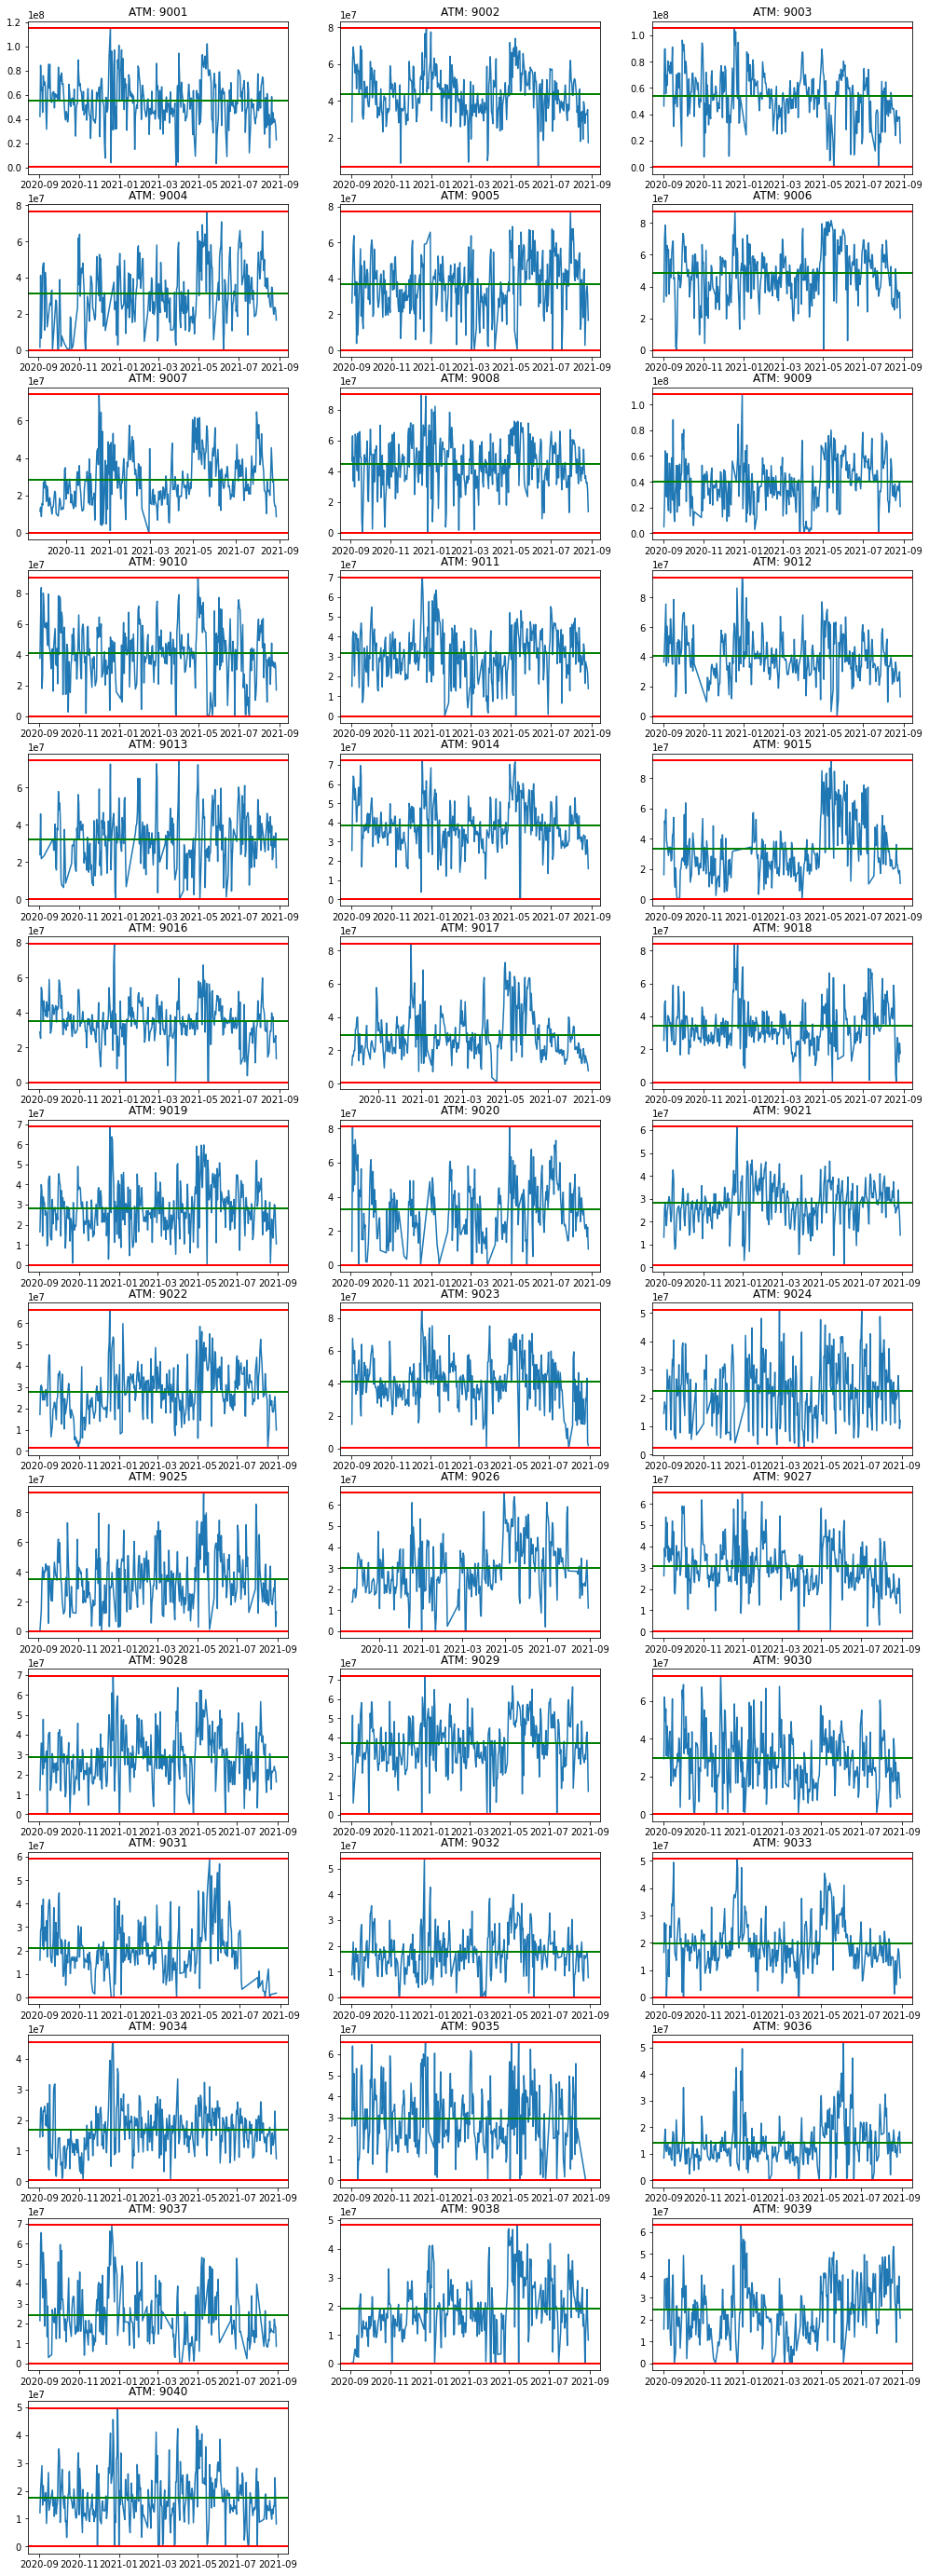

Wall time: 7.75 s


In [8]:
%%time
#Despliegue de gráficas tiempo/total_dispensado por cada ATM

i=1
plt.figure(figsize=(17, 50))
for atm, new_df in data.groupby(level = 0):
    dplot = new_df.reset_index()
    plt.subplot(14,3,i);
    plt.plot(dplot['TIMESTAMP'], dplot['MONTO_TRX']);
    plt.axhline(new_df['MONTO_TRX'].max(),linewidth=2, color='r' )
    plt.axhline(new_df['MONTO_TRX'].mean(),linewidth=2, color='g' )
    plt.axhline(new_df['MONTO_TRX'].min(),linewidth=2, color='r' )
    label = 'ATM: ' + str(atm)
    plt.title(label)    
    i=i+1;
plt.show()

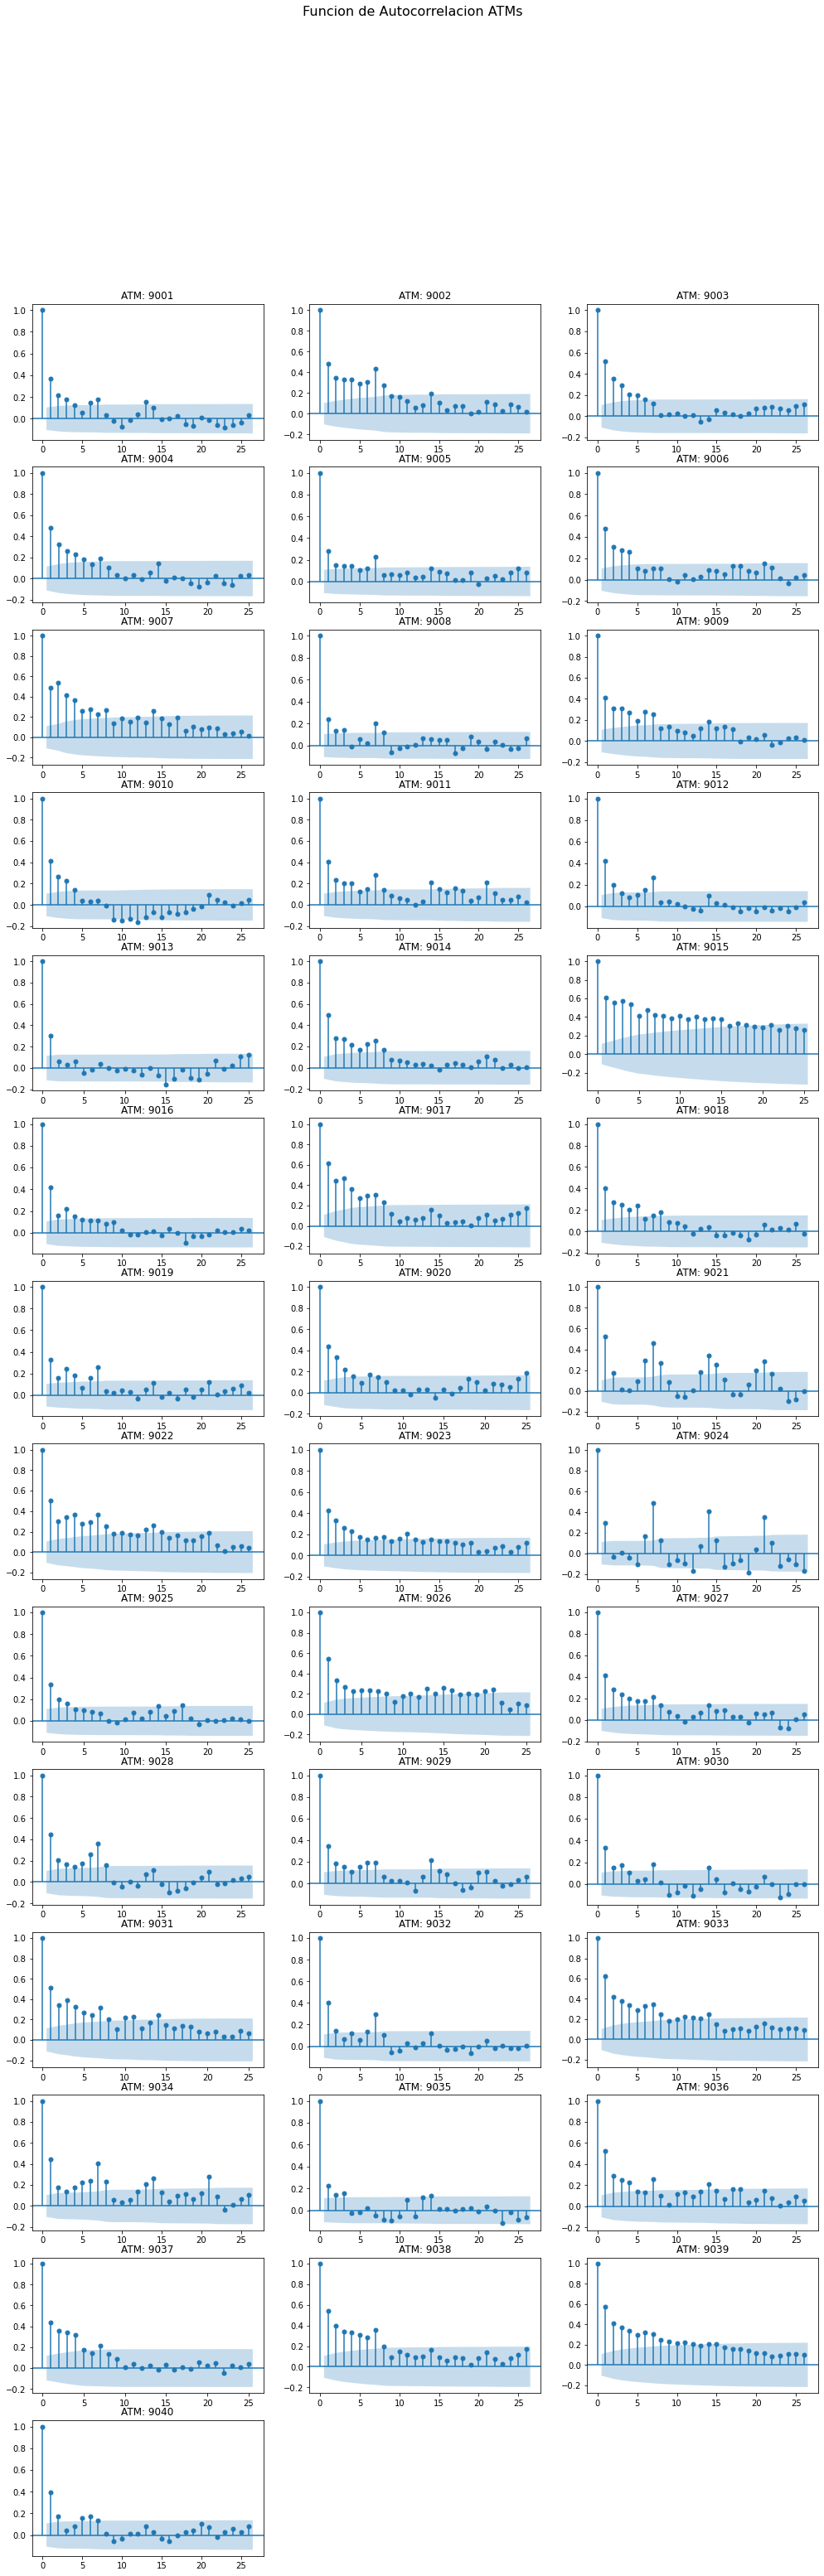

Wall time: 8.58 s


In [9]:
%%time
#Despliegue de función de autocorrelación por cada ATM

from statsmodels.graphics.tsaplots import plot_acf
#from statsmodels.graphics.tsaplots import plot_pacf


i=1
fig = plt.figure(figsize=(17, 50))
fig.suptitle('Funcion de Autocorrelacion ATMs', fontsize=16)
for atm, new_df in data.groupby(level = 0):
    dplot = new_df.reset_index()
    dplot = dplot.drop(columns=['TERMINAL_NUMBER'])
    dplot = dplot.set_index('TIMESTAMP')
    ax = fig.add_subplot(14,3,i)
    ax = plot_acf(dplot, title = 'Autocorrelacion ATMs', ax=ax)
    label = 'ATM: ' + str(atm)
    plt.title(label)
    i=i+1;
plt.show()

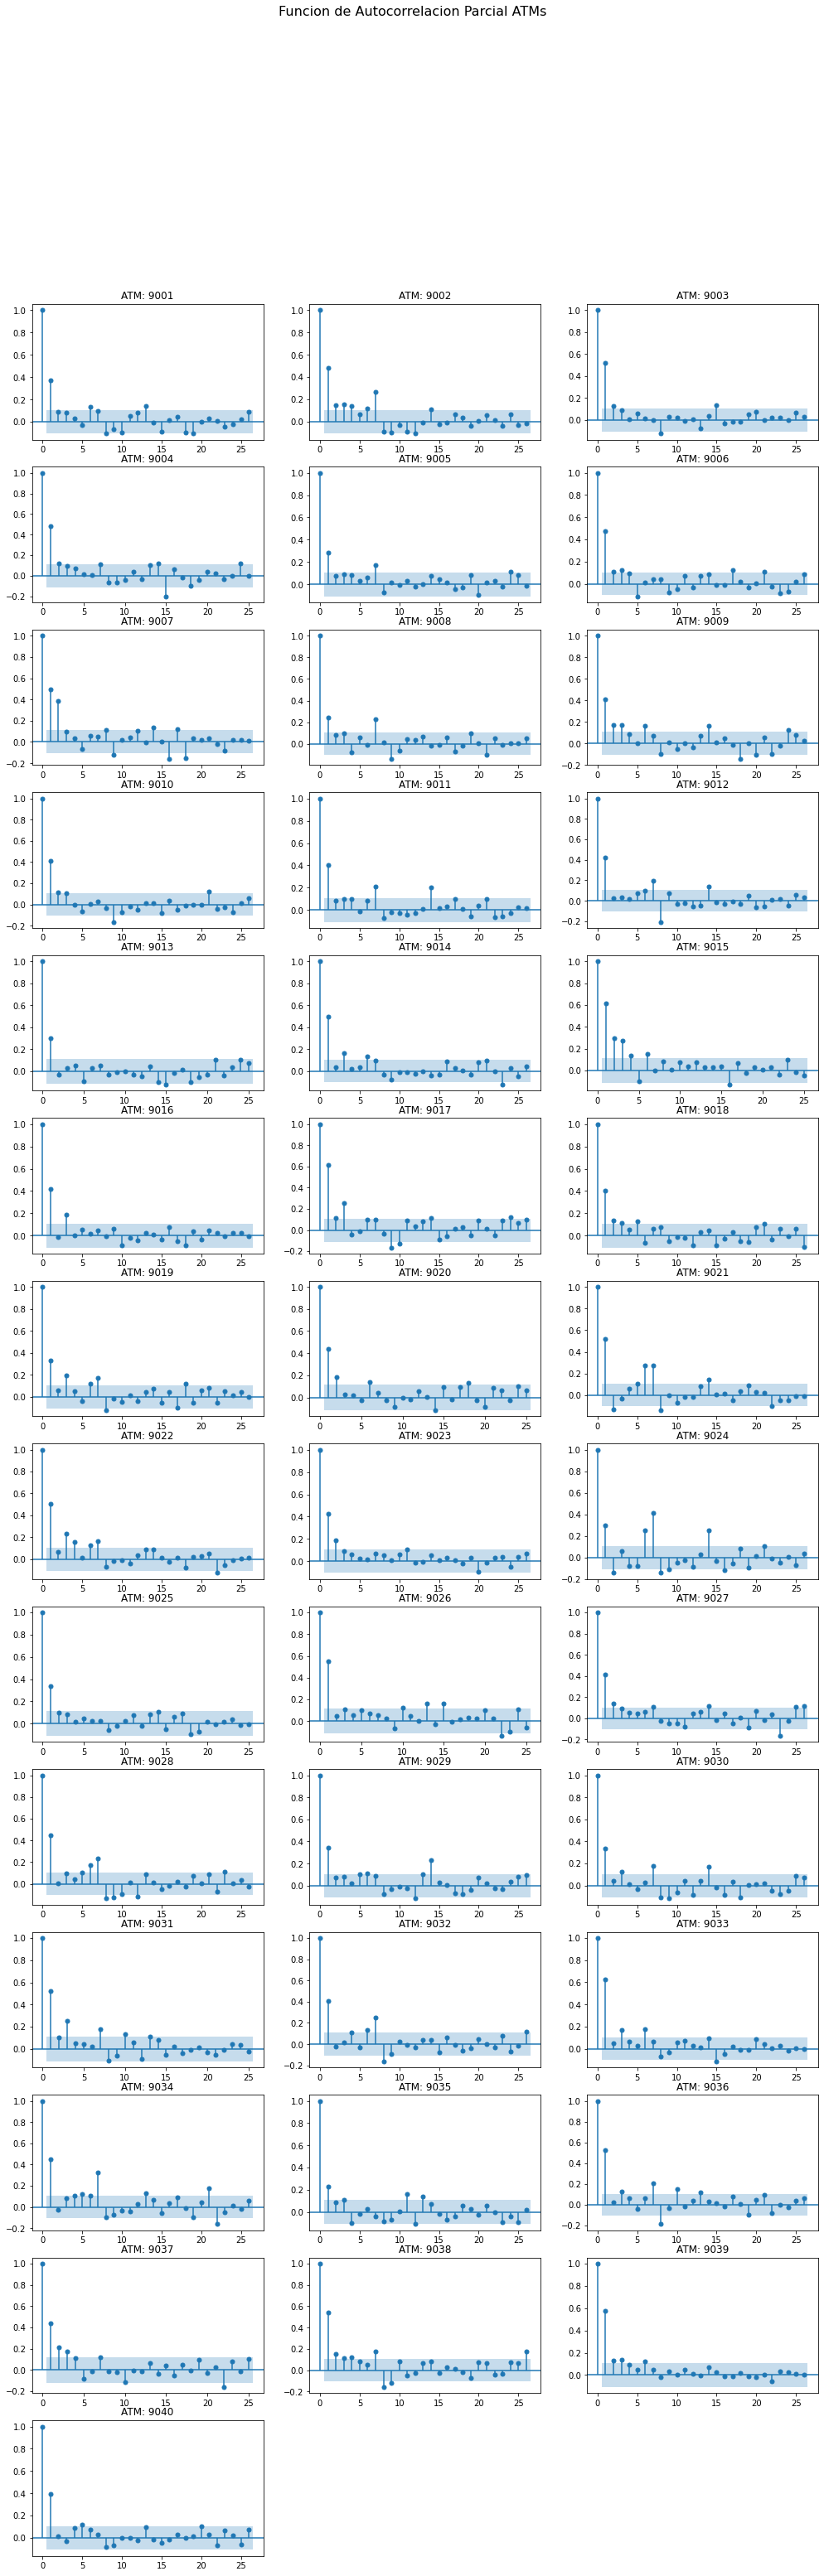

Wall time: 6.54 s


In [10]:
%%time
#Despliegue de función de autocorrelación parcial por cada ATM

#from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf


i=1
fig = plt.figure(figsize=(17, 50))
fig.suptitle('Funcion de Autocorrelacion Parcial ATMs', fontsize=16)
for atm, new_df in data.groupby(level = 0):
    dplot = new_df.reset_index()
    dplot = dplot.drop(columns=['TERMINAL_NUMBER'])
    dplot = dplot.set_index('TIMESTAMP')
    ax = fig.add_subplot(14,3,i)
    ax = plot_pacf(dplot, title = 'Autocorrelacion Pacial ATMs', ax=ax)
    label = 'ATM: ' + str(atm)
    plt.title(label)
    i=i+1;
plt.show()

In [11]:
%%time
#Generación del vector de la función de autocorrelación parcial de todos los ATMs

from statsmodels.tsa.stattools import pacf
pacf_vector_array = np.empty((0,26))
for atm, new_df in data.groupby(level = 0):
    dplot = new_df.reset_index()
    dplot = dplot.drop(columns=['TERMINAL_NUMBER'])
    dplot = dplot.set_index('TIMESTAMP')
    pacf_vector = pacf(dplot,nlags=25)
    pacf_vector_array = np.append(pacf_vector_array, np.array([pacf_vector]), axis=0)
print (pacf_vector_array)
pd.set_option('display.max_columns', 12)
vector_df = pd.DataFrame(pacf_vector_array)
vector_df = vector_df.drop(columns=0)
vector_df

[[ 1.          0.36855992  0.09073131 ... -0.04483211 -0.02463071
   0.02108336]
 [ 1.          0.48306626  0.14794226 ... -0.03567681  0.06845433
  -0.02993288]
 [ 1.          0.51721648  0.12434349 ...  0.0182045  -0.00284451
   0.06321189]
 ...
 [ 1.          0.53992545  0.15368129 ... -0.03687215  0.07564335
   0.06599736]
 [ 1.          0.57513673  0.12920069 ...  0.03645539  0.02438539
   0.0107466 ]
 [ 1.          0.39685063  0.01479407 ...  0.06953851  0.02010732
  -0.06360389]]
Wall time: 708 ms


,1,2,3,4,5,6,...,20,21,22,23,24,25
0,0.368560,0.090731,0.084844,0.028128,-0.028603,0.136722,...,0.002617,0.031965,0.010913,-0.044832,-0.024631,0.021083
1,0.483066,0.147942,0.153994,0.143384,0.063511,0.116095,...,0.010081,0.057004,0.013782,-0.035677,0.068454,-0.029933
2,0.517216,0.124343,0.090878,0.009006,0.061751,0.016357,...,0.072603,-0.000523,0.017680,0.018205,-0.002845,0.063212
3,0.484948,0.116232,0.092018,0.070696,0.017203,0.003429,...,0.039650,0.026227,-0.036884,-0.001279,0.118352,-0.002662
4,0.284367,0.078328,0.092470,0.081626,0.031981,0.061616,...,-0.096861,0.015805,0.031298,-0.020072,0.112360,0.085214
5,0.475864,0.110648,0.121620,0.095069,-0.112395,0.014110,...,0.005697,0.108817,-0.023583,-0.089367,-0.070349,0.016958
6,0.491758,0.388922,0.098500,0.037115,-0.070181,0.056966,...,0.022727,0.031584,-0.016415,-0.083294,0.016247,0.016624
7,0.243452,0.082182,0.099649,-0.075265,0.057060,-0.012507,...,0.005419,-0.101721,0.049038,-0.008777,0.003328,0.006932
8,0.409437,0.171048,0.173933,0.088002,0.004905,0.160551,...,-0.105063,0.056584,-0.095488,-0.019189,0.121293,0.077979
9,0.412384,0.116639,0.104347,-0.006289,-0.064340,0.006552,...,-0.004534,0.118966,-0.041127,-0.026542,-0.076575,0.014620


In [12]:
#!pip install yellowbrick

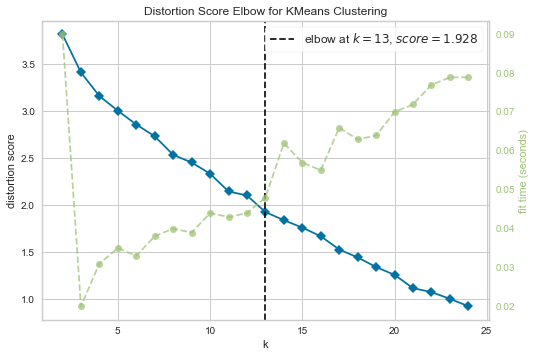

Wall time: 10.4 s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
%%time
#Trabajando con un visualizador de KElbow Method
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,25))

visualizer.fit(vector_df)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [14]:
model.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 24,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [15]:
%%time
#Se agregan las features asociadas a la definición de cada ATM para experimentar si eso genera un cambio indicativo para la
#identificación del número de clusters
from sklearn.preprocessing import minmax_scale

vector_df_features = vector_df.copy()
vector_df_features.insert(25, "TOTAL_GIROS",'NaN')
vector_df_features.insert(26, "ESTABLECIMIENTO",'NaN')
vector_df_features.insert(27, "DISPONIBILIDAD",'NaN')
i=0
for index,row in csv_def.iterrows():
    vector_df_features.at[i,'TOTAL_GIROS']=row[1]
    vector_df_features.at[i,'ESTABLECIMIENTO']=row[4]
    vector_df_features.at[i,'DISPONIBILIDAD']=row[5]
    i=i+1
    
pd.set_option('display.max_columns', 12)
vector_df_features[['TOTAL_GIROS','ESTABLECIMIENTO', 'DISPONIBILIDAD']] = minmax_scale(vector_df_features[['TOTAL_GIROS','ESTABLECIMIENTO', 'DISPONIBILIDAD']])
vector_df_features

Wall time: 301 ms


,1,2,3,4,5,6,...,23,24,25,TOTAL_GIROS,ESTABLECIMIENTO,DISPONIBILIDAD
0,0.368560,0.090731,0.084844,0.028128,-0.028603,0.136722,...,-0.044832,-0.024631,0.021083,1.000000,0.500000,0.0
1,0.483066,0.147942,0.153994,0.143384,0.063511,0.116095,...,-0.035677,0.068454,-0.029933,0.820155,0.500000,0.0
2,0.517216,0.124343,0.090878,0.009006,0.061751,0.016357,...,0.018205,-0.002845,0.063212,0.758159,0.500000,0.0
3,0.484948,0.116232,0.092018,0.070696,0.017203,0.003429,...,-0.001279,0.118352,-0.002662,0.694011,1.000000,1.0
4,0.284367,0.078328,0.092470,0.081626,0.031981,0.061616,...,-0.020072,0.112360,0.085214,0.682209,1.000000,1.0
5,0.475864,0.110648,0.121620,0.095069,-0.112395,0.014110,...,-0.089367,-0.070349,0.016958,0.680734,0.500000,0.0
6,0.491758,0.388922,0.098500,0.037115,-0.070181,0.056966,...,-0.083294,0.016247,0.016624,0.669621,1.000000,1.0
7,0.243452,0.082182,0.099649,-0.075265,0.057060,-0.012507,...,-0.008777,0.003328,0.006932,0.647686,0.500000,0.0
8,0.409437,0.171048,0.173933,0.088002,0.004905,0.160551,...,-0.019189,0.121293,0.077979,0.640770,0.500000,0.0
9,0.412384,0.116639,0.104347,-0.006289,-0.064340,0.006552,...,-0.026542,-0.076575,0.014620,0.627226,0.500000,0.0


In [16]:
#Se eliminan las observaciones de los instantes de tiempo posteriores a t-16
vector_df_features = vector_df_features.drop(vector_df_features.iloc[:, 15:25], axis = 1)
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 1000)
vector_df_features

,1,2,3,4,5,...,14,15,TOTAL_GIROS,ESTABLECIMIENTO,DISPONIBILIDAD
0,0.368560,0.090731,0.084844,0.028128,-0.028603,...,-0.010176,-0.087453,1.000000,0.500000,0.0
1,0.483066,0.147942,0.153994,0.143384,0.063511,...,0.111401,-0.018817,0.820155,0.500000,0.0
2,0.517216,0.124343,0.090878,0.009006,0.061751,...,0.034131,0.131788,0.758159,0.500000,0.0
3,0.484948,0.116232,0.092018,0.070696,0.017203,...,0.122563,-0.198750,0.694011,1.000000,1.0
4,0.284367,0.078328,0.092470,0.081626,0.031981,...,0.078008,0.042960,0.682209,1.000000,1.0
5,0.475864,0.110648,0.121620,0.095069,-0.112395,...,0.087954,-0.012620,0.680734,0.500000,0.0
6,0.491758,0.388922,0.098500,0.037115,-0.070181,...,0.137894,-0.000033,0.669621,1.000000,1.0
7,0.243452,0.082182,0.099649,-0.075265,0.057060,...,-0.018964,-0.010509,0.647686,0.500000,0.0
8,0.409437,0.171048,0.173933,0.088002,0.004905,...,0.161549,0.008595,0.640770,0.500000,0.0
9,0.412384,0.116639,0.104347,-0.006289,-0.064340,...,0.011199,-0.083152,0.627226,0.500000,0.0


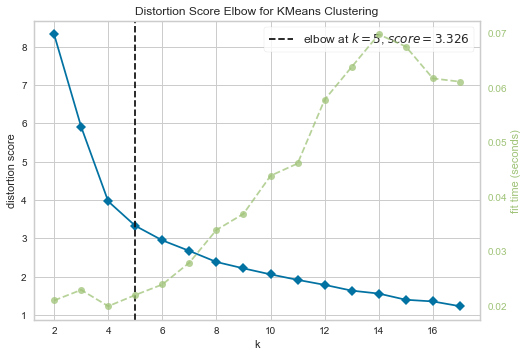

Wall time: 1.28 s


<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [17]:
%%time
#Trabajando con un visualizador de KElbow Method

from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

X = vector_df_features
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,18))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [18]:
model.get_params()

{'algorithm': 'auto',
 'copy_x': True,
 'init': 'k-means++',
 'max_iter': 300,
 'n_clusters': 17,
 'n_init': 10,
 'n_jobs': 'deprecated',
 'precompute_distances': 'deprecated',
 'random_state': None,
 'tol': 0.0001,
 'verbose': 0}

In [21]:
# %%time
#pip install tslearn

from tslearn.clustering import TimeSeriesKMeans
cluster_count = 5

km_sdtw = TimeSeriesKMeans(n_clusters=cluster_count, 
                          verbose=2, 
                          n_init=10, 
                          metric="softdtw").fit(vector_df_features)
labels_sdtw = km_sdtw.labels_

Init 1
Resumed because of empty cluster
Init 1
Resumed because of empty cluster
Init 1
698.745 --> 727.520 --> 728.638 --> 728.802 --> 728.804 --> 728.804 --> 728.804 --> 728.804 --> 728.804 --> 
Init 2
703.640 --> 727.428 --> 728.524 --> 728.577 --> 728.580 --> 728.580 --> 728.580 --> 728.580 --> 
Init 3
Resumed because of empty cluster
Init 3
Resumed because of empty cluster
Init 3
694.831 --> 727.298 --> 728.225 --> 728.249 --> 728.259 --> 728.260 --> 728.260 --> 728.260 --> 728.260 --> 728.260 --> 
Init 4
Resumed because of empty cluster
Init 4
Resumed because of empty cluster
Init 4
Resumed because of empty cluster


In [22]:
%%time
km_dtw = TimeSeriesKMeans(n_clusters=cluster_count, 
                          verbose=2, 
                          n_init=10, 
                          metric="dtw").fit(vector_df_features)
labels_dtw = km_dtw.labels_

Init 1
0.080 --> 0.057 --> 0.056 --> 0.055 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.055 --> 0.055 --> 
Init 2
0.081 --> 0.059 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.058 --> 0.058 --> 0.058 --> 
Init 3
0.085 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.056 --> 0.055 --> 0.055 --> 
Init 4
0.091 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.054 --> 0.054 --> 
Init 5
0.084 --> 0.062 --> 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0

0.060 --> 0.060 --> 
Init 6
0.078 --> 0.055 --> 0.055 --> 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.055 --> 
Init 7
0.085 --> 0.058 --> 0.058 --> 

[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Paral


Init 8
0.081 --> 0.054 --> 0.054 --> 
Init 9


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.083 --> 0.056 --> 0.056 --> 0.056 --> 
Init 10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent work

0.079 --> 0.054 --> 0.054 --> 0.054 --> 
Wall time: 2.2 s


[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 200 out of 200 | elapsed:    0.0s finished


In [23]:
%%time
km_euc = TimeSeriesKMeans(n_clusters=cluster_count, 
                          verbose=2, 
                          n_init=10, 
                          metric="euclidean").fit(vector_df_features)
labels_euc = km_euc.labels_

Init 1
0.169 --> 0.094 --> 0.089 --> 0.089 --> 
Init 2
0.156 --> 0.093 --> 0.093 --> 
Init 3
0.131 --> 0.083 --> 0.083 --> 
Init 4
0.157 --> 0.104 --> 0.098 --> 0.094 --> 0.094 --> 
Init 5
0.149 --> 0.089 --> 0.088 --> 0.088 --> 
Init 6
0.186 --> 0.127 --> 0.127 --> 
Init 7
0.145 --> 0.091 --> 0.091 --> 
Init 8
0.152 --> 0.093 --> 0.092 --> 0.092 --> 
Init 9
0.139 --> 0.090 --> 0.089 --> 0.089 --> 
Init 10
0.178 --> 0.124 --> 0.123 --> 0.123 --> 
Wall time: 219 ms


In [24]:
%%time

from tslearn.clustering import silhouette_score

print ('ssilhouette_score - Euclidean: ' , silhouette_score(vector_df_features, labels_euc, metric="euclidean"))
print ('ssilhouette_score - DTW: ' , silhouette_score(vector_df_features, labels_dtw, metric="dtw"))
print ('ssilhouette_score - Soft DTW: ' , silhouette_score(vector_df_features, labels_sdtw, metric="softdtw"))

ssilhouette_score - Euclidean:  0.44095916584912837
ssilhouette_score - DTW:  0.15383160943476132
ssilhouette_score - Soft DTW:  0.6365088600549612
Wall time: 329 ms


In [28]:
km_euc.get_params()

{'dtw_inertia': False,
 'init': 'k-means++',
 'max_iter': 50,
 'max_iter_barycenter': 100,
 'metric': 'euclidean',
 'metric_params': None,
 'n_clusters': 5,
 'n_init': 10,
 'n_jobs': None,
 'random_state': None,
 'tol': 1e-06,
 'verbose': 2}

In [46]:
km_sdtw

TimeSeriesKMeans(metric='softdtw', n_clusters=6, n_init=10, verbose=2)

In [89]:
print('Clusters usando K-Means Soft DTW: ' , labels_sdtw)

Clusters usando K-Means Soft DTW:  [2 2 2 0 0 2 0 2 2 2 0 2 0 2 0 2 0 2 2 0 3 4 2 0 0 0 2 2 2 0 1 1 1 1 4 1 0
 1 4 4]


In [88]:
labels_sdtw.shape

(40,)